In [1]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
#allow access to current google drive
from google.colab import drive
drive.mount('/content/drive')

corpus = []
with open('/content/drive/My Drive/MLAH/project/corpuses/67kbCorpus.txt') as inputfile:
    for line in inputfile:
        x = line.strip()
        if x != '':
            corpus.append(line.strip('();:.,"!?\n  '))

corpus

Mounted at /content/drive


['If we think dishonestly, or malignantly, our thoughts',
 'will die like evil fungi – dripping corrupt dew\xa0',
 'The smell –',
 'wet anorak, fusty books, disturbed dust',
 'of long unopened doors –',
 'like the basement of your childhood',
 'beautiful scary darkness',
 'They poke',
 'their tiny heads through dirt',
 'explorers from another age, and find',
 'a world glassy with rain, a forest',
 'thick with leaf mulch',
 'A good one',
 'if you’re starving, could save',
 'your life. A bad one would kill you',
 'after only one bite. Step on its poison head',
 'it billows black fumes',
 'Lost in the woods',
 'and hungry, how to tell them apart',
 'You can trust the feel of flesh on your tongue',
 'good meat – you know it won’t hurt you',
 'you’re a bit of a witch yourself',
 'How many summers is it together',
 'with your vents and doors open',
 'how many springs',
 'full of self-important shoots',
 'how many autumns',
 'dusty and home to spiders',
 'and how many winters',
 'shut, inward

In [4]:
line_count = len(corpus)
line_count

1699

In [5]:
import random
random.sample(corpus, 8)

['in these unspoken places',
 'Ignorant or sussed',
 'In the photograph, Venus looks cool',
 'misted windows',
 'as they perform their repertoire of whistles',
 'constant coaches cross',
 "Leaving Springtime's pledge",
 'this chameleon moon']

In [6]:
#for saving model
import os
checkpoint_path = "save_model/cp.ckpt"
checkpoint_dir = "/content/drive/MyDrive/MLAH/project/save_model"
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, save_weights_only=True, verbose=1)

In [7]:
tokenizer = Tokenizer()
#takes one sentence at a time and establishes dictionary of tokens 
tokenizer.fit_on_texts(corpus)
# + 1 to the end of the index to cater for the 'padding' (zero) token
total_words = len(tokenizer.word_index)+1
#total number of unique words
total_words

2158

In [8]:
#we now have a list of sentences and a dictionary of tokenized words
#time to turn them into training data
#n-grams are used to seperate out our sentences into a sequence of 
#tokens representing the sequential flow of words.
#	- so  	[4, 2, 54, 73, 8, 98, 11]

#	- ==  	[4, 2]
#	      	[4, 2, 54]
#	      	[4, 2, 54, 73]
#	      	[4, 2, 54, 73, 8]
#	      	[4, 2, 54, 73, 8, 98]
#	      	[4, 2, 54, 73, 8, 98, 11]
input_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0] #from each line, generate the list of tokens (integers)
  for i in range(1, len(token_list)): #generate an n-gram for each line
    n_gran_sequence = token_list[:i+1]
    input_sequences.append(n_gran_sequence)  

In [9]:
#padding
#	-  	[0, 0, 0, 0, 0, 4, 2]
#	    [0, 0, 0, 0, 4, 2, 54]
#	    [0, 0, 0, 4, 2, 54, 73]
#	    [0, 0, 4, 2, 54, 73, 8]
#	    [0, 4, 2, 54, 73, 8, 98]
#	    [4, 2, 54, 73, 8, 98, 11]
#we pad so we can extract features and labels,
#everything but the last value is the feature and the last value is the label
#            input    label
#              |        |
#	-	 (0 0 0 0 0 4) (2)
#	-	 (0 0 0 0 4 2) (54)
#   -    etc...

#pad each n-gram sequence with 0 up to size of the longest sentence
import numpy as np
max_sequence_len = max([len(x) for x in input_sequences]) #get the longest sentence legnth
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

#slice input sequence into x and label
xs = input_sequences[:, :-1] #x is everything in a sequence up to the last word
labels = input_sequences[:, -1] #label is the last word of every sequence

#one-hot encode y labels
#now we have labels for training we classify each label as an integer matrix the size of the amount of labels
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
#max_sequence_len
#len(xs)
len(labels)

8234

In [33]:
def create_model():
    model = Sequential()
    #embedding - where the sentiment vectors are learnt for each word
    #(unique words in corpus, dimensions, x input length (-1 because x is everything in a sequence up to the last word))
    #can alter dimension value if model repeats output regularly
    model.add(Embedding(total_words, 1000, input_length=max_sequence_len-1))
    #Bidirectional LSTM can understand context better
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words, activation='softmax'))
    #model.add(Dense(total_words, activation='softmax',kernel_regularizer=regularizers.l2(0.01)))
    adam = Adam(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    #earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    return model

#create an instance of the model
model_instance = create_model()

In [34]:
!ls {checkpoint_dir}

 checkpoint  'cp.ckpt (2).data-00000-of-00001'	 cp.ckpt.index


In [36]:
history = model_instance.fit(xs, ys, 
                    epochs=60, 
                    verbose=1, 
                    callbacks=[cp_callback]) # Pass callback to training
print(model_instance)
model_instance.summary()

Epoch 1/60
258/258 [==============================] - 15s 43ms/step - loss: 6.8186 - accuracy: 0.0745

Epoch 00001: saving model to /content/drive/MyDrive/MLAH/project/save_model
Epoch 2/60
258/258 [==============================] - 11s 44ms/step - loss: 4.7968 - accuracy: 0.2139

Epoch 00002: saving model to /content/drive/MyDrive/MLAH/project/save_model
Epoch 3/60
258/258 [==============================] - 11s 43ms/step - loss: 3.1779 - accuracy: 0.3951

Epoch 00003: saving model to /content/drive/MyDrive/MLAH/project/save_model
Epoch 4/60
258/258 [==============================] - 11s 43ms/step - loss: 2.4216 - accuracy: 0.4859

Epoch 00004: saving model to /content/drive/MyDrive/MLAH/project/save_model
Epoch 5/60
258/258 [==============================] - 12s 45ms/step - loss: 1.8616 - accuracy: 0.5958

Epoch 00005: saving model to /content/drive/MyDrive/MLAH/project/save_model
Epoch 6/60
258/258 [==============================] - 11s 43ms/step - loss: 1.5420 - accuracy: 0.6536

Ep

In [37]:
#for running saved model
#savedModel = create_model()
#checkpoint_path = "drive/MyDrive/MLAH/project/save_model/cp.ckpt.index"
#savedModel.load_weights(checkpoint_path).expect_partial()

seed_text = "as i"
next_words = 25
WordCount = 0
sentenceString = ""

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model_instance.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			seed_text += " " + output_word
			break
print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


as i perceive the level of gravity increasing so my desire to defy it increases all hungry to sea sea in drowsy chill tangle in the noonday


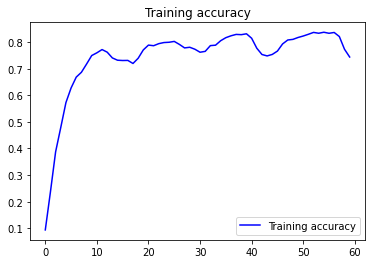

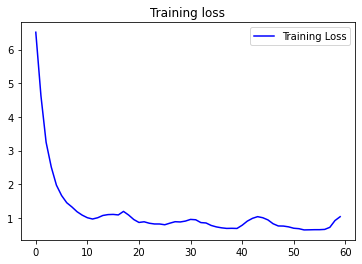

In [38]:
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

#we are training with very unstructured data and its trying to figure out how to match x and y